In [1]:
import cv2
import time
import numpy as np
from numpy import *
from PIL import Image
import Optimizer_with_theano as op
import Optimizer_with_theano.Datasets as data
from matplotlib.pyplot import *
import pickle


# Emotion Detector
class emotion_detector():
    def __init__(self, num_datasets=1000, cnum = 0, image_size=(20,20)):
        self.num_datasets = num_datasets
        self.cnum = cnum
        self.image_size = image_size
        
    def get_train_data(self, is_mouth=False):
        input("Ready to laugh...")
        laugh_img = self.take_photos(is_mouth)
        input("Ready to anger...")
        anger_img = self.take_photos(is_mouth)
        input("Ready to sad...")
        sad_img = self.take_photos(is_mouth)
        input("Ready to fun...")
        fun_img = self.take_photos(is_mouth)
        self.facelst = [laugh_img, anger_img, sad_img, fun_img]
        
    def train(self, lr=0.001, n_batch=10, n_epoch=100, n_view=10):
        self.x_arr = array(self.facelst, dtype=float).reshape(self.num_datasets * 4, -1)
        self.x_arr /= 255
        self.y_arr = data.gen_one_hot(arange(4).repeat(self.num_datasets)[:, None])
        self.o = op.optimizer(self.x_arr, self.y_arr, n_batch=n_batch)
        self.o = self.o.dense(10,act="relu")
        self.o = self.o.dense(100,act="relu")
        self.o = self.o.dense(200,act="relu")
        self.o = self.o.dense(300,act="relu")
        self.o = self.o.dense(400,act="relu")
        self.o = self.o.dense(4).softmax()
        self.o = self.o.loss_cross_entropy()
        self.o = self.o.opt_Adam(lr).compile()
        self.o = self.o.optimize(n_epoch, n_view)
    
    def cam_test(self):
        cv2.namedWindow("preview")
        vc = cv2.VideoCapture(self.cnum)
        tof, frame = vc.read()
        return tof
    
    def take_photos(self, is_mouth=True):
        cv2.namedWindow("preview")
        vc = cv2.VideoCapture(self.cnum)
        haarFace = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        haarMouth = cv2.CascadeClassifier('haarcascade_mouth.xml')
        
        lst = []
        rval, frame = vc.read()
        #tof, self.frame = vc.read()
        for i in range(self.num_datasets):
            cv2.imshow("preview", frame)
            rval, frame = vc.read()
        
                
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
        
        # running the classifiers
            detectedFace = haarFace.detectMultiScale(frame_gray)
        
            x, y, width, height = detectedFace[array([x[2]*x[3] for x in detectedFace]).argmax()]
        
            face = frame_gray[y:y+height, x:x+width]
            #cv2.imshow("face", face)
            #cv2.waitKey(100)
           
            if not is_mouth:
                lst += [cv2.resize(face,self.image_size)]
            elif is_mouth:
                rects = haarMouth.detectMultiScale(face, 1.3, minSize=(50,50))
                self. rects = rects
                if len(rects):
                    rect = rects[array([x[1] for x in rects]).argmax()]
                    mouth = face[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[1]]
                    #for rect in rects:
                    #    cv2.rectangle(face, tuple(rect[0:2]),tuple(rect[0:2]+rect[2:4]), (0,0,255), thickness=2)
                    cv2.imshow("mouth", mouth)
                    lst += [cv2.resize(mouth,self.image_size)]
            
            cv2.imshow("face", face)
            cv2.waitKey(1)  
        return lst
        cv2.destroyWindow("preview")
            
    def dump_pickle(self, fname="emotion.pkl"):
        with open(fname, mode='wb') as f:
            pickle.dump(self, f)
            
        
    def load_pickle(self, fname="emotion.pkl"):
        with open(fname, mode='rb') as f:
            return pickle.load(f)
        
    def detect(self, is_mouth=True):
        cv2.namedWindow("preview")
        vc = cv2.VideoCapture(self.cnum)
        haarFace = cv2.CascadeClassifier('haarcascade_frontalface_default.xml')
        haarMouth = cv2.CascadeClassifier('haarcascade_mouth.xml')
        emolst = ["laugh", "anger", "sad", "fun"]
        lst = []
        rval, frame = vc.read()
        
        
        # 動画の読み込みと動画情報の取得 
        fps    = vc.get(cv2.CAP_PROP_FPS)
        height = vc.get(cv2.CAP_PROP_FRAME_HEIGHT)
        width  = vc.get(cv2.CAP_PROP_FRAME_WIDTH)
        
        # 出力先のファイルを開く
        out = cv2.VideoWriter("output.mv4", int(cv2.VideoWriter_fourcc('m', 'p', '4', 'v')), fps, (int(width), int(height)))
        
        while True:
            cv2.imshow("preview", frame)
            out.write(frame)
            num = cv2.waitKey(1)
            if num == "q":
                break
            rval, frame = vc.read()
            frame_gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY) 
            
            detectedFace = haarFace.detectMultiScale(frame_gray)
            if not len(detectedFace):
                continue
                
            x, y, width, height = detectedFace[array([x[2]*x[3] for x in detectedFace]).argmax()]
            
            face = frame_gray[y:y+height, x:x+width]
           
            if not is_mouth:
                lst += [cv2.resize(face,self.image_size)]
            elif is_mouth:
                rects = haarMouth.detectMultiScale(face, 1.3, minSize=(50,50))
                self.rects = rects
                if len(rects):
                    rect = rects[array([x[1] for x in rects]).argmax()]
                    mouth = face[rect[1]:rect[1]+rect[3], rect[0]:rect[0]+rect[1]]
                    #cv2.imshow("mouth", mouth)
                    ans = emolst[int(a.o.pred_func(cv2.resize(mouth,self.image_size).reshape(1,-1))[0])]
                    cv2.putText(frame, ans, (50, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 0, 255), 3)#, cv2.CV_AA)
            #cv2.imshow("face", face)
            

        cv2.destroyWindow("preview")
        out.release()
        return lst            
        #for rect in detectedFace:
        #cv2.rectangle(frame, tuple(rect[0:2]),tuple(rect[0:2]+rect[2:4]), (255,255,255), thickness=2)
        #rect[0] += x
        #rect[1] += y
        #cv2.rectangle(frame, tuple(rect[0:2]),tuple(rect[0:2]+rect[2:4]), (0,0,255), thickness=2)
        
            #    cv.rectangle()
            #if mouth != 2: # did not return error    
            #    mouthimg = crop(mouth)
            #    cv.imwrite("webcam-m.jpg", mouthimg)
        #result = lr.predict(mouth.reshape(1,-1))
        #result = lr.predict(cv.resize(mouth,(10,28)).reshape(1,-1))
        #if result == 1:
        #   print ("you are smiling! :-) ")
        #else:
        #    print ("you are not smiling :-| ")
       # else:
       #     print ("failed to detect mouth. Try hold your head straight and make sure there is only one face.")

        

In [ ]:
a = emotion_detector()
a.get_train_data(False)
#a.train(n_batch=300, n_epoch=1000)
#a.detect()
#a = emotion_detector().load_pickle()
#a.get_train_data(True)
#a.dump_pickle()

Ready to laugh...


/Users/yu/.pyenv/versions/anaconda3-4.1.1/lib/python3.5/site-packages/theano/gof/cc.py:944: UserWarning: Your g++ compiler fails to compile OpenMP code. We know this happen with some version of the EPD mingw compiler and LLVM compiler on Mac OS X. We disable openmp everywhere in Theano. To remove this warning set the theano flags `openmp` to False.
  ret += x.c_compile_args()


layer 0
name:Input_0
in:(400,)
out:(400,)
layer 1
name:Dense_1
in:(400,)
out:(10,)
Num of params:4010
Params:
------------------------------------
Dense_1_b:[10]
Dense_1_theta:[400  10]
------------------------------------
activation:relu
layer 2
name:Dense_2
in:(10,)
out:(100,)
Num of params:1100
Params:
------------------------------------
Dense_2_b:[100]
Dense_2_theta:[ 10 100]
------------------------------------
activation:relu
layer 3
name:Dense_3
in:(100,)
out:(200,)
Num of params:20200
Params:
------------------------------------
Dense_3_b:[200]
Dense_3_theta:[100 200]
------------------------------------
activation:relu
layer 4
name:Dense_4
in:(200,)
out:(300,)
Num of params:60300
Params:
------------------------------------
Dense_4_theta:[200 300]
Dense_4_b:[300]
------------------------------------
activation:relu
layer 5
name:Dense_5
in:(300,)
out:(400,)
Num of params:120400
Params:
------------------------------------
Dense_5_theta:[300 400]
Dense_5_b:[400]
---------------

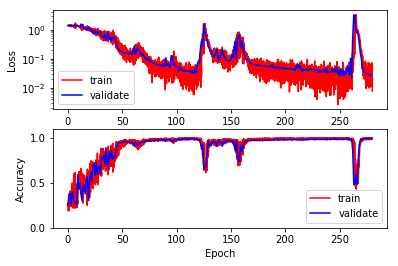

In [ ]:
a.detect()

In [7]:
pwd

'/Users/yu/emotion_detector'

In [4]:
# -*- coding: utf-8 -*-

import numpy as np
import cv2

fps = 15
size = (640,480)

cap = cv2.VideoCapture(0)
cap.set(3, size[0])  # Width
cap.set(4, size[1])  # Heigh
cap.set(5, fps)   # FPS

fourcc = cv2.VideoWriter_fourcc(*'DIB ')
out = cv2.VideoWriter('output.avi',fourcc, fps, size)

while(cap.isOpened()):
    ret, frame = cap.read()
    if ret==True:
        out.write(frame)
        cv2.imshow('frame',frame)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    else:
        break

# Release
cap.release()
out.release()
cv2.destroyAllWindows()


In [2]:
import glob as g

In [4]:
pathlst = g.glob("default/*")

In [15]:
path = "default"
size = 20

xlst = []
ylst = []


for i, emo in enumerate(["laugh", "anger", "sad", "fun"]):
    for p in g.glob(path+"/{}/*".format(emo)):
        xlst += [cv2.resize(cv2.imread(p,0), (20,20))]
        ylst += [i]
        
#g.glob(path+"/*")

In [13]:
cv2.resize?